ssh root@192.168.2.1

The default password is analog.

You should see the PlutoSDR welcome screen. You have now SSHed into the ARM CPU on the Pluto itself!

If you have a Pluto with firmware version 0.31 or lower, type the following commands in:

fw_setenv attr_name compatible
fw_setenv attr_val ad9364
reboot

And for 0.32 and higher use:

fw_setenv compatible ad9364
reboot



In [47]:
import numpy as np
import adi
import matplotlib.pyplot as plt

sample_rate = 56e6 # Hz
center_freq = 1.6e9 # Hz
num_samps = 100000 # number of samples per call to rx()

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -10 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = num_samps
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC

# Create transmit waveform (pure phase modulation)


number_of_tx_samples = 16000
t = np.linspace(0,2.0*np.pi,number_of_tx_samples)
modulation_frequency = 5e6
beta = 0.125*np.pi

normalized_angular_frequency= modulation_frequency/sample_rate*number_of_tx_samples
print(normalized_angular_frequency)

phase = beta*np.sin(normalized_angular_frequency*t)

p = np.sin(phase+0.02)
q = np.cos(phase)

samples = p+1j*q # samples as a complex number

# samples = np.ones(number_of_tx_samples)
samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(samples) # start transmitting

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()



1428.5714285714287


100000


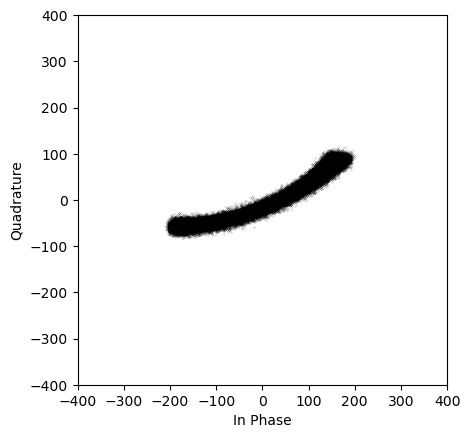

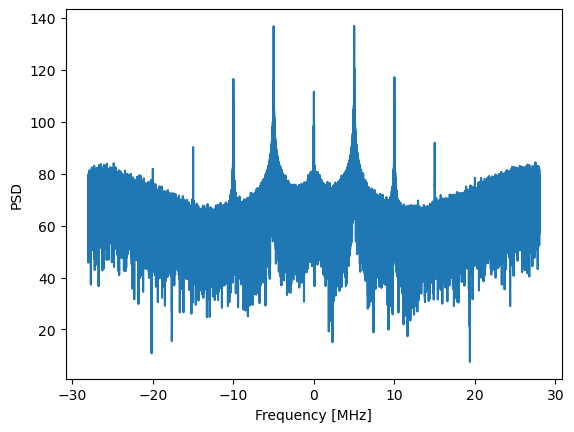

In [50]:
# Receive samples
rx_samples = sdr.rx()

# Stop transmitting
#sdr.tx_destroy_buffer()

# Calculate power spectral density (frequency domain version of signal)
psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
psd_dB = 10*np.log10(psd)
f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))

# Plot I/Q diagram
plt.figure(0)
plt.plot(np.real(rx_samples), np.imag(rx_samples), 'ko', markersize=0.1)
plt.xlabel("In Phase")
plt.ylabel("Quadrature")
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.0)
plt.xlim((-400,400))
plt.ylim((-400,400))
print(len(rx_samples))

# Plot freq domain
plt.figure(1)
plt.plot(f/1e6,psd_dB)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.show()

In [79]:
# Stop transmitting
sdr.tx_destroy_buffer()

In [21]:
import time
for center_freq in range(990,1200):
    sdr.tx_lo = int(center_freq*1e6)
    time.sleep(0.1)